# Setup

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00:00:0100:01


100%|██████████| 4.17M/4.17M [00:04<00:00, 850kB/s] 


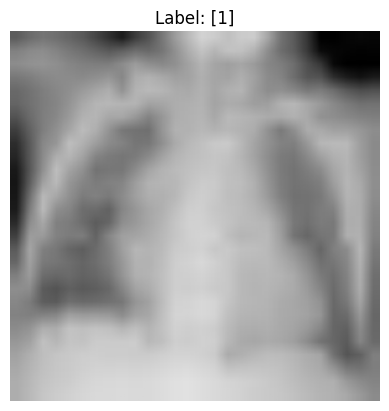

Training Class Distribution: {0: 1214, 1: 3494}


In [1]:
!pip install -q medmnist
from medmnist import PneumoniaMNIST
from medmnist import INFO
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Setting the data flag
data_flag = 'pneumoniamnist'
download = True

# Getting dataset info
info = INFO[data_flag]
DataClass = getattr(__import__('medmnist'), info['python_class'])

# Defining transform (convert grayscale to RGB later for InceptionV3)
data_transform = transforms.Compose([
    transforms.Resize((299, 299)),          # For InceptionV3
    transforms.Grayscale(num_output_channels=3), # Convert 1 channel → 3 channels
    transforms.ToTensor()
])

# Loading datasets
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset   = DataClass(split='val',   transform=data_transform, download=download)
test_dataset  = DataClass(split='test',  transform=data_transform, download=download)

# Sample inspection
image, label = train_dataset[0]
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# Class distribution in train set
labels_np = np.array([sample[1] for sample in train_dataset])
unique, counts = np.unique(labels_np, return_counts=True)
print("Training Class Distribution:", dict(zip(unique, counts)))


# Data splitting and data loading

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Runnung a mini batch
for batch in train_loader:
    images, labels = batch
    print(images.shape, labels.shape)
    break


torch.Size([32, 3, 299, 299]) torch.Size([32, 1])


# Starting with inceptionv3

In [5]:
from torchvision.models import inception_v3
import torch.nn as nn

model = inception_v3(pretrained=True, aux_logits=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last inception block
for name, param in model.named_parameters():
    if "Mixed_7c" in name:
        param.requires_grad = True

# Replace the main classifier head (ImageNet has 1000 outputs → we want 1)
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 1)  # Binary classification → single output
)

# Also replace aux classifier (it also outputs 1000 by default)
model.AuxLogits.fc = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1)
)

#Finding trainable layers
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 205MB/s] 


AuxLogits.fc.0.weight
AuxLogits.fc.0.bias
AuxLogits.fc.3.weight
AuxLogits.fc.3.bias
Mixed_7c.branch1x1.conv.weight
Mixed_7c.branch1x1.bn.weight
Mixed_7c.branch1x1.bn.bias
Mixed_7c.branch3x3_1.conv.weight
Mixed_7c.branch3x3_1.bn.weight
Mixed_7c.branch3x3_1.bn.bias
Mixed_7c.branch3x3_2a.conv.weight
Mixed_7c.branch3x3_2a.bn.weight
Mixed_7c.branch3x3_2a.bn.bias
Mixed_7c.branch3x3_2b.conv.weight
Mixed_7c.branch3x3_2b.bn.weight
Mixed_7c.branch3x3_2b.bn.bias
Mixed_7c.branch3x3dbl_1.conv.weight
Mixed_7c.branch3x3dbl_1.bn.weight
Mixed_7c.branch3x3dbl_1.bn.bias
Mixed_7c.branch3x3dbl_2.conv.weight
Mixed_7c.branch3x3dbl_2.bn.weight
Mixed_7c.branch3x3dbl_2.bn.bias
Mixed_7c.branch3x3dbl_3a.conv.weight
Mixed_7c.branch3x3dbl_3a.bn.weight
Mixed_7c.branch3x3dbl_3a.bn.bias
Mixed_7c.branch3x3dbl_3b.conv.weight
Mixed_7c.branch3x3dbl_3b.bn.weight
Mixed_7c.branch3x3dbl_3b.bn.bias
Mixed_7c.branch_pool.conv.weight
Mixed_7c.branch_pool.bn.weight
Mixed_7c.branch_pool.bn.bias
fc.0.weight
fc.0.bias
fc.3.weight
fc.

# Model training 

In [6]:
import time
import torch
import copy
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

EPOCHS = 50
PATIENCE = 10

# Early stopping setup
best_auc = 0
best_model_wts = copy.deepcopy(model.state_dict())
no_improve_epochs = 0

print("🚀 Starting training with early stopping...\n")

for epoch in range(EPOCHS):
    print(f"\n🟩 Epoch {epoch+1}/{EPOCHS}")
    start_time = time.time()

    # ========== TRAIN ==========
    model.train()
    train_losses, train_labels, train_preds = [], [], []

    train_start = time.time()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.float().to(device).squeeze(1)

        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs, aux_outputs = outputs
            outputs = outputs.squeeze(1)
            aux_outputs = aux_outputs.squeeze(1)

            loss_main = criterion(outputs, labels)
            loss_aux = criterion(aux_outputs, labels)
            loss = loss_main + 0.4 * loss_aux
        else:
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(preds.cpu().numpy())

    train_time = time.time() - train_start
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds)
    train_auc = roc_auc_score(train_labels, train_preds)

    # ========== VALIDATION ==========
    model.eval()
    val_losses, val_labels, val_preds, val_probs = [], [], [], []

    val_start = time.time()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device).squeeze(1)

            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            outputs = outputs.squeeze(1)

            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    val_time = time.time() - val_start
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    val_auc = roc_auc_score(val_labels, val_probs)

    # ========== LOG ==========
    print(f"📦 Train Samples: {len(train_labels)} | Val Samples: {len(val_labels)}")
    print(f"📉 Train Loss: {sum(train_losses)/len(train_losses):.4f}")
    print(f"📈 Train Acc: {train_acc:.4f} | F1: {train_f1:.4f} | AUC: {train_auc:.4f}")
    print(f"🔍 Val   Acc: {val_acc:.4f} | F1: {val_f1:.4f} | AUC: {val_auc:.4f}")
    print(f"⏱️  Time → Train: {train_time:.2f}s | Val: {val_time:.2f}s | Total: {time.time() - start_time:.2f}s")

    # ========== EARLY STOPPING ==========
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model.pt')  # Save best model
        print("✅ AUC improved — model saved.")
    else:
        no_improve_epochs += 1
        print(f"⚠️  No improvement in AUC for {no_improve_epochs} epoch(s).")

    if no_improve_epochs >= PATIENCE:
        print(f"\n⛔ Early stopping triggered after {PATIENCE} epochs with no AUC improvement.")
        break

# Load best model weights
model.load_state_dict(best_model_wts)
print("\n🏁 Training complete. Best validation AUC: {:.4f}".format(best_auc))


🚀 Starting training with early stopping...


🟩 Epoch 1/50
📦 Train Samples: 4708 | Val Samples: 524
📉 Train Loss: 0.4489
📈 Train Acc: 0.8672 | F1: 0.9133 | AUC: 0.7966
🔍 Val   Acc: 0.9084 | F1: 0.9381 | AUC: 0.9661
⏱️  Time → Train: 23.14s | Val: 2.22s | Total: 25.38s
✅ AUC improved — model saved.

🟩 Epoch 2/50
📦 Train Samples: 4708 | Val Samples: 524
📉 Train Loss: 0.2371
📈 Train Acc: 0.9465 | F1: 0.9640 | AUC: 0.9290
🔍 Val   Acc: 0.9218 | F1: 0.9470 | AUC: 0.9750
⏱️  Time → Train: 22.94s | Val: 2.26s | Total: 25.22s
✅ AUC improved — model saved.

🟩 Epoch 3/50
📦 Train Samples: 4708 | Val Samples: 524
📉 Train Loss: 0.1687
📈 Train Acc: 0.9743 | F1: 0.9827 | AUC: 0.9679
🔍 Val   Acc: 0.9351 | F1: 0.9555 | AUC: 0.9778
⏱️  Time → Train: 22.81s | Val: 2.26s | Total: 25.08s
✅ AUC improved — model saved.

🟩 Epoch 4/50
📦 Train Samples: 4708 | Val Samples: 524
📉 Train Loss: 0.1232
📈 Train Acc: 0.9877 | F1: 0.9917 | AUC: 0.9852
🔍 Val   Acc: 0.9256 | F1: 0.9497 | AUC: 0.9772
⏱️  Time → Train: 22.60s

# Starting Evaluation

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Load best model weights
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().to(device).squeeze(1)

        outputs = model(images)
        if isinstance(outputs, tuple):  # Just in case
            outputs = outputs[0]
        outputs = outputs.squeeze(1)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Metrics + Classification Report

In [8]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)
test_auc = roc_auc_score(all_labels, all_probs)

print("✅ Final Test Set Evaluation")
print(f"Accuracy : {test_acc:.4f}")
print(f"F1 Score : {test_f1:.4f}")
print(f"AUC-ROC  : {test_auc:.4f}")


✅ Final Test Set Evaluation
Accuracy : 0.8750
F1 Score : 0.9076
AUC-ROC  : 0.9553


# Confusion matrix

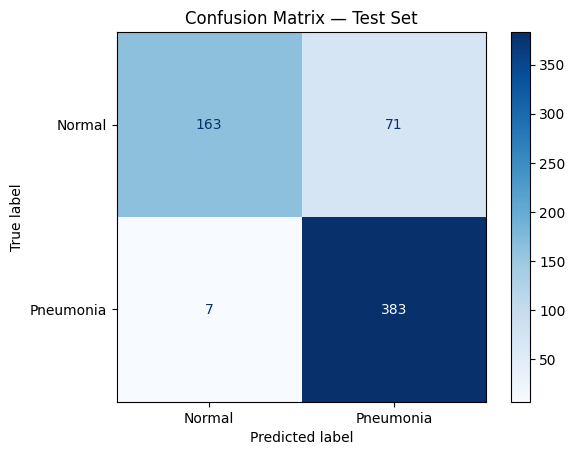

In [9]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Test Set")
plt.savefig("Confusion matrix.png")
plt.show()


# Misclassified sample: False negative

/tmp/ipykernel_35/152359732.py:30: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.savefig("false negative.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


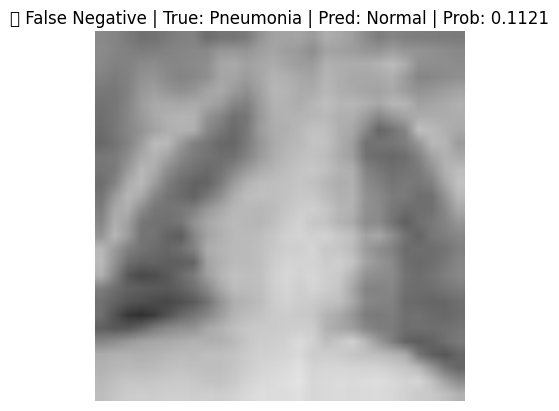

In [10]:
import numpy as np

false_negatives = []

model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.float().to(device).squeeze(1)

        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        outputs = outputs.squeeze(1)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        for j in range(images.size(0)):
            if labels[j] == 1.0 and preds[j] == 0.0:  # False Negative
                false_negatives.append((images[j].cpu(), probs[j].cpu(), i * test_loader.batch_size + j))

# Pick the first one
image_tensor, prob, idx = false_negatives[0]

# Display it
import matplotlib.pyplot as plt
plt.imshow(np.transpose(image_tensor.numpy(), (1, 2, 0)), cmap='gray')
plt.title(f"❌ False Negative | True: Pneumonia | Pred: Normal | Prob: {prob.item():.4f}")
plt.savefig("false negative.png")
plt.axis('off')
plt.show()


# Applying gradcam

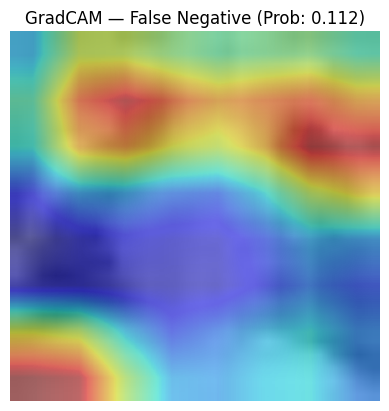

In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchcam.methods import GradCAM
from torchvision.transforms.functional import normalize

# Load model
model.load_state_dict(torch.load("best_model.pt"))
model.eval().to(device)

# Initialize GradCAM
cam_extractor = GradCAM(model, target_layer="Mixed_7c")

# Loop to find a false negative — NO torch.no_grad() here
found = False
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.float().to(device).squeeze(1)

    images.requires_grad = True  # 💡 Enable gradient tracking

    outputs = model(images)
    if isinstance(outputs, tuple):
        outputs = outputs[0]
    outputs = outputs.squeeze(1)

    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float()

    for j in range(images.size(0)):
        if labels[j] == 1.0 and preds[j] == 0.0:  # False negative
            image_tensor = images[j].detach().cpu()
            prob = probs[j].detach().cpu()
            input_tensor = image_tensor.unsqueeze(0).to(device)
            input_tensor.requires_grad = True
            found = True
            break
    if found:
        break

# Normalize input as InceptionV3 expects
input_tensor = normalize(input_tensor,
                         mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

# Forward pass for GradCAM
output = model(input_tensor)
if isinstance(output, tuple):
    output = output[0]

# Generate GradCAM for predicted class (0 = normal)
activation_map = cam_extractor(0, output)

# Resize CAM to 299x299
heatmap = F.interpolate(activation_map[0].unsqueeze(0), size=(299, 299), mode='bilinear', align_corners=False)
heatmap = heatmap.squeeze().cpu()

# Prepare original image
img_np = np.transpose(image_tensor.numpy(), (1, 2, 0))
plt.imshow(img_np, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title(f"GradCAM — False Negative (Prob: {prob.item():.3f})")
plt.axis('off')
plt.savefig("gradcam_false_negative_final.png", bbox_inches='tight')
plt.show()
